In [18]:
import pandas as pd
import joblib
import re
import sys
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import xgboost as xgb
from scipy.sparse import hstack
import matplotlib.pyplot as plt

sys.path.append(str(Path.cwd().parent))
from utils.helpers import create_features, clean_text 

# Load the pre-processed and pre-balanced dataset
processed_file_path = Path('../data/processed_reviews.csv')
if not processed_file_path.exists():
    raise FileNotFoundError("Processed data file not found. Please run '1_Data_Processing.ipynb' first.")
df_train = pd.read_csv(processed_file_path).dropna()

print(f"Loaded {len(df_train)} balanced reviews for training.")

Loaded 672 balanced reviews for training.


In [19]:
# 1. Create our original nuanced features
print("Creating base features...")
base_features = create_features(df_train)

# 2. Create TF-IDF features from the cleaned text
print("Creating TF-IDF features...")
tfidf_vectorizer = TfidfVectorizer(max_features=3000) # Use top 3000 words
tfidf_features = tfidf_vectorizer.fit_transform(df_train['cleaned_text'])

# 3. Combine base features and TF-IDF features
print("Combining all features...")
X = hstack([tfidf_features, base_features])
y = df_train['is_fake']

Creating base features...
Creating TF-IDF features...
Combining all features...


In [20]:
# Split data for training and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train the XGBoost model
print("Training XGBoost Classifier...")
xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
print("Model training complete.")

Training XGBoost Classifier...


Model training complete.



--- Validation Set Performance (XGBoost) ---
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        68
           1       0.97      1.00      0.99        67

    accuracy                           0.99       135
   macro avg       0.99      0.99      0.99       135
weighted avg       0.99      0.99      0.99       135



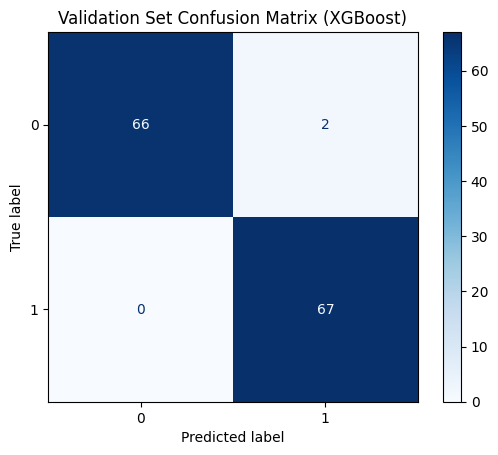

In [21]:
print("\n--- Validation Set Performance (XGBoost) ---")
y_pred_val = xgb_model.predict(X_val)
print(classification_report(y_val, y_pred_val))
ConfusionMatrixDisplay.from_estimator(xgb_model, X_val, y_val, cmap=plt.cm.Blues)
plt.title('Validation Set Confusion Matrix (XGBoost)')
plt.show()

In [22]:
# --- FINAL TEST SET EVALUATION ---
test_file_path = Path('../data/test.ft.txt')
print("\nLoading and parsing final test data...")
test_data = []
with open(test_file_path, 'r', encoding='utf-8') as f:
    for line in f:
        parts = line.split(' ', 1)
        if len(parts) == 2:
            label_str, text = parts
            label = int(re.search(r'\d+', label_str).group())
            test_data.append({'rating_class': label, 'review_text': text.strip()})

df_test = pd.DataFrame(test_data)

# Prepare the test data in the exact same way as the training data
df_test['word_count'] = df_test['review_text'].apply(lambda x: len(str(x).split()))
word_count_threshold = 15
df_test['is_fake'] = df_test['word_count'].apply(lambda x: 1 if x < word_count_threshold else 0)
df_test['cleaned_text'] = df_test['review_text'].apply(clean_text)

# Create features for the final test set
base_features_test = create_features(df_test)
tfidf_features_test = tfidf_vectorizer.transform(df_test['cleaned_text'])
X_test_final = hstack([tfidf_features_test, base_features_test])
y_test_final = df_test['is_fake']

print("Final test data prepared.")


Loading and parsing final test data...
Final test data prepared.



--- Final Test Set Performance (XGBoost) ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    399930
           1       0.06      1.00      0.11        70

    accuracy                           1.00    400000
   macro avg       0.53      1.00      0.56    400000
weighted avg       1.00      1.00      1.00    400000



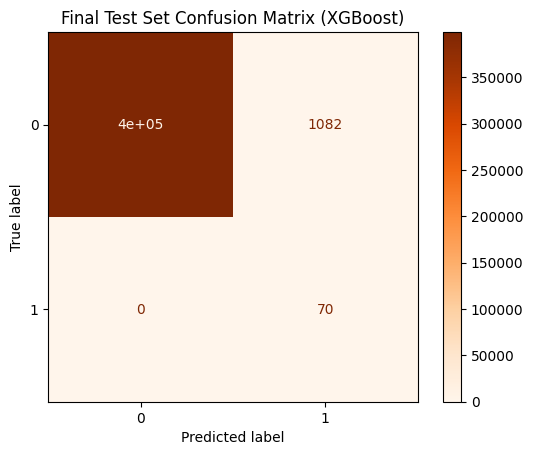

In [23]:
print("\n--- Final Test Set Performance (XGBoost) ---")
y_pred_final = xgb_model.predict(X_test_final)
print(classification_report(y_test_final, y_pred_final))
ConfusionMatrixDisplay.from_estimator(xgb_model, X_test_final, y_test_final, cmap=plt.cm.Oranges)
plt.title('Final Test Set Confusion Matrix (XGBoost)')
plt.show()

In [24]:
# Save the trained model and the TF-IDF vectorizer
model_dir = Path('../models')
model_dir.mkdir(exist_ok=True)

joblib.dump(xgb_model, model_dir / 'fake_review_model.pkl')
joblib.dump(tfidf_vectorizer, model_dir / 'tfidf_vectorizer.pkl')

print(f"\nNew XGBoost model saved to {model_dir / 'fake_review_model.pkl'}")
print(f"TF-IDF Vectorizer saved to {model_dir / 'tfidf_vectorizer.pkl'}")


New XGBoost model saved to ..\models\fake_review_model.pkl
TF-IDF Vectorizer saved to ..\models\tfidf_vectorizer.pkl
